### Requirements

In [134]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Considerations

Columns to consider including:
- `DisplayName`.. That's how users mention each other '@ExampleDisplayName' but `DisplayName` has many missing values. 

Columns to consider excluding:
- `Tags` should we create these ourselves?

### Dataset introduction
We have chosen to work with data from stackexchange.politics. The data is part of Stackoverflow's Data Dump: https://archive.org/details/stackexchange.

For additional descriptions on the dataset, please refer to this meta.stackexchange post: https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede/2678#2678 

**The tables we have chosen to work with:**
- `Comments`
- `Posts`
- `PostLinks`
- `Tags`
- `Users`

**The tables we have chosen to omit:**
- `Badges`
- `PostHistory`
- `Votes`

**The columns we have chosen to work with:**
- `Comments`: 'Id', 'PostId', 'Score', 'Text', 'CreationDate', 'UserId'
- `Posts`: 'Id', 'PostTypeId', 'ParentId', 'AcceptedAnswerId', 'CreationDate',
       'Score', 'ViewCount', 'Body', 'OwnerUserId', 'LastActivityDate',
       'Title', 'Tags', 'AnswerCount', 'CommentCount'
- `PostLinks`: 'Id', 'CreationDate', 'PostId', 'RelatedPostId', 'LinkTypeId'
- `Tags`: 'Id', 'TagName', 'Count'
- `Users`: 'Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'Views',
       'UpVotes', 'DownVotes'

**The columns we have chosen to omit:**
- `Comments`: 'UserDisplayName', 'ContentLicense'
- `Posts`: 'FavoriteCount', 'ContentLicense'
- `PostLinks`:
- `Tags`: 'ExcerptPostId', 'WikiPostId'
- `Users`: 'WebsiteUrl', 'Location', 'AboutMe', 'Views', 'UpVotes', 'DownVotes', 'ProfileImageUrl', 'AccountId'


>**ChatGPT** I want to discover communities and "subject matter experts" within the forum (my dataset). Therefore, I want to group every post into >the category that best describe it. Many posts have tags like "`united-states`", "`congress`", "`european-union`", "`local-government`", "`administrative-division`". 

> Some tags are more descriptive than others. What could I use to find proper categorizing? 
> - TF-IDF
> - LSH 
> - or similar 

>I want to ignore the preexistent tags and categorize all posts. How much control do I have on the amount of categories found? Thereafter, I want >to use clustering (e.g., K-means) to identify groups of users based on their activity patterns (like number of questions, answers, average likes, >and the category they engage the most in). Help me get started.

> How can I find if posts with a certain tag, say "`congress`" are really more similar/closer to each other than e.g. posts categorized using TF-IDF?

### Read in all dataframes

In [38]:
# Define columns for each DataFrame
comment_cols = ['Id', 'PostId', 'Score', 'Text', 'CreationDate', 'UserId']
post_cols = [
    'Id', 'PostTypeId', 'ParentId', 'AcceptedAnswerId', 'CreationDate', 
    'Score', 'ViewCount', 'Body', 'OwnerUserId', 'LastActivityDate', 
    'Title', 'Tags', 'AnswerCount', 'CommentCount'
]
post_links_cols = ['Id', 'CreationDate', 'PostId', 'RelatedPostId', 'LinkTypeId']
tags_cols = ['Id', 'TagName', 'Count']
user_cols = ['Id', 'Reputation', 'CreationDate', 'LastAccessDate', 'Views', 'UpVotes', 'DownVotes']

# Load DataFrames
df_comments = pd.read_csv('./output/Comments.csv', usecols=comment_cols)
df_posts = pd.read_excel('./output/Posts.xlsx', usecols=post_cols)
df_posts_links = pd.read_csv('./output/PostLinks.csv', usecols=post_links_cols)
df_tags = pd.read_csv('./output/Tags.csv', usecols=tags_cols)
df_users = pd.read_csv('./output/Users.csv', usecols=user_cols)

### Missing values

In [39]:
if df_comments.isnull().sum().any():
    print('df_comments.isnull().sum()', '\n', df_comments.isnull().sum()[df_comments.isnull().sum() > 0], '\n', sep='')

if df_posts.isnull().sum().any():
    print('df_posts.isnull().sum()', '\n', df_posts.isnull().sum()[df_posts.isnull().sum() > 0], '\n', sep='')

if df_posts_links.isnull().sum().any():
    print('df_posts_links.isnull().sum()', '\n', df_posts_links.isnull().sum()[df_posts_links.isnull().sum() > 0], '\n', sep='')

if df_tags.isnull().sum().any():
    print('df_tags.isnull().sum()', '\n', df_tags.isnull().sum()[df_tags.isnull().sum() > 0], '\n', sep='')

if df_users.isnull().sum().any():
    print('df_users.isnull().sum()', '\n', df_users.isnull().sum()[df_users.isnull().sum() > 0], '\n', sep='')

df_comments.isnull().sum()
UserId    8841
dtype: int64

df_posts.isnull().sum()
ParentId            17652
AcceptedAnswerId    45425
ViewCount           37740
Body                  602
OwnerUserId          2322
Title               37740
Tags                37740
AnswerCount         37740
dtype: int64



**Trying to explain the missing values**


**`df_comments`**
- `UserId` is absent if the user has been deleted 

**`df_posts`**
- `ParentId` only present if PostTypeId = 2
- `AcceptedAnswerId` only present if PostTypeId = 1
- `ViewCount` only present if PostTypeId = 1
- `Body` not present in some PostTypeId = [4,5]. We will only look at PostTypeId = [1,2]
    - PostTypeId = 1: Question
    - PostTypeId = 2: Answer
    - PostTypeId = 4: Tag wiki excerpt
    - Check documentation
- `OwnerUserId` only present if user has not been deleted
- `Title` question title only present if PostTypeId = 1
- `Tags` question tags only present if PostTypeId = 1    
- `AnswerCount` only present if PostTypeId = 1

**How we will take action**

**`df_comments`**
- `UserId`: Before we remove comments from deleted users, we want to calculate average sentiment of threads users engage in. To calculate the average sentiment polarity of a thread, we want to include every user's comments. We therefore temporarily replace missing `UserId` with (-1).

**`df_posts`**
- We're only interested in PostTypeId 1 (Question) and 2 (Answer), so we filter out other types.
- For the below columns which are conditionally present, we fill missing values with a placeholder (-1 or 'Comment: N/A') 
    - ParentId, 
    - AcceptedAnswerId, 
    - ViewCount, 
    - Title, 
    - Tags, and 
    - AnswerCount
- For OwnerUserId, similar to the UserId in comments, we fill missing values with a placeholder (-1)

In [40]:
# df_comments
df_comments['UserId'] = df_comments['UserId'].fillna(-1)

# df_posts
df_posts = df_posts[df_posts['PostTypeId'].isin([1, 2])]

df_posts['OwnerUserId'] = df_posts['OwnerUserId'].fillna(-1)
df_posts.fillna({'ParentId': -1, 'AcceptedAnswerId': -1, 'ViewCount': -1, 'Title': 'Comment: N/A', 'Tags': 'Comment: N/A', 'AnswerCount': -1}, inplace=True)

In [41]:
print(df_comments.isnull().sum().any())
print(df_posts.isnull().sum().any())

False
False


### df_comments

In [42]:
print(df_comments.info(), '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184672 entries, 0 to 184671
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Id            184672 non-null  int64  
 1   PostId        184672 non-null  int64  
 2   Score         184672 non-null  int64  
 3   Text          184672 non-null  object 
 4   CreationDate  184672 non-null  object 
 5   UserId        184672 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 8.5+ MB
None 



### Quick look the dataframe

In [43]:
df_comments.head()

,Id,PostId,Score,Text,CreationDate,UserId
0,1,1,9,Is it fair to inquire about the disadvantages ...,2012-12-04T22:00:00.933,28.0
1,3,1,3,"I could have reformulated the question, but at...",2012-12-04T22:02:37.737,18.0
2,7,2,2,Source on this? I don't see how it could possi...,2012-12-04T22:10:10.070,45.0
3,13,2,1,@Nick122 In a parliamentary system like the No...,2012-12-04T22:14:33.463,43.0
4,15,2,0,"Yes, but you will give a negative vote by voti...",2012-12-04T22:16:29.437,45.0


### Typecasting

In [44]:
df_comments = df_comments.astype({
    'Id': 'int32',
    'PostId': 'int32',
    'Score': 'int16',
    'Text': 'object',
    'CreationDate': 'datetime64[ns]',
    #'UserDisplayName': 'string',
    'UserId': 'int32'
})

In [45]:
df_comments.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184672 entries, 0 to 184671
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Id            184672 non-null  int32         
 1   PostId        184672 non-null  int32         
 2   Score         184672 non-null  int16         
 3   Text          184672 non-null  object        
 4   CreationDate  184672 non-null  datetime64[ns]
 5   UserId        184672 non-null  int32         
dtypes: datetime64[ns](1), int16(1), int32(3), object(1)
memory usage: 5.3+ MB


### df_posts

In [46]:
df_posts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52092 entries, 0 to 53741
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                52092 non-null  int64  
 1   PostTypeId        52092 non-null  int64  
 2   ParentId          52092 non-null  float64
 3   AcceptedAnswerId  52092 non-null  float64
 4   CreationDate      52092 non-null  object 
 5   Score             52092 non-null  int64  
 6   ViewCount         52092 non-null  float64
 7   Body              52092 non-null  object 
 8   OwnerUserId       52092 non-null  float64
 9   LastActivityDate  52092 non-null  object 
 10  Title             52092 non-null  object 
 11  Tags              52092 non-null  object 
 12  AnswerCount       52092 non-null  float64
 13  CommentCount      52092 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 6.0+ MB


### Quick look the posts dataframe

In [47]:
df_posts.head()

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount
0,1,1,-1.0,5.0,2012-12-04T21:40:29.743,42,8309.0,<p>We all know the situation could arise in th...,18.0,2019-06-29T09:18:38.430,What are the disadvantages of first-past-the-p...,<election><voting-systems><first-past-the-post>,3.0,3
1,2,1,-1.0,19.0,2012-12-04T21:53:18.800,26,7832.0,<p>I've heard that mathematically it can be sh...,21.0,2017-05-03T13:53:26.063,Why can't voting be fair if there are more tha...,<voting><political-theory><voting-systems>,4.0,3
2,4,2,1.0,-1.0,2012-12-04T21:58:11.187,7,-1.0,<p>First-past-the-post voting tends to result ...,26.0,2012-12-04T21:58:11.187,Comment: N/A,Comment: N/A,-1.0,1
3,5,2,1.0,-1.0,2012-12-04T21:58:39.037,47,-1.0,<p>Simple plurality voting has very little in ...,8.0,2012-12-04T22:04:42.767,Comment: N/A,Comment: N/A,-1.0,1
4,6,1,-1.0,28.0,2012-12-04T21:58:47.500,46,68096.0,<p>Living in a country where mandatory voting ...,18.0,2019-02-03T17:38:05.237,What are the advantages/disadvantages of a man...,<voting><voting-systems>,8.0,5


### Typecasting

In [48]:
df_posts = df_posts.astype({
    'Id': 'int32',
    'PostTypeId': 'int32',
    'ParentId': 'int32',
    'AcceptedAnswerId': 'int16',
    'CreationDate': 'datetime64[ns]',
    'Score': 'int16',
    'ViewCount': 'int32',
    'Body': 'object',
    'OwnerUserId': 'int32',
    'LastActivityDate': 'datetime64[ns]',
    'Title': 'string',
    'Tags': 'string',
    'AnswerCount': 'int16',
    'CommentCount': 'int16'
    #'FavoriteCount': 'int16'
})

In [49]:
df_posts.info()


<class 'pandas.core.frame.DataFrame'>
Index: 52092 entries, 0 to 53741
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Id                52092 non-null  int32         
 1   PostTypeId        52092 non-null  int32         
 2   ParentId          52092 non-null  int32         
 3   AcceptedAnswerId  52092 non-null  int16         
 4   CreationDate      52092 non-null  datetime64[ns]
 5   Score             52092 non-null  int16         
 6   ViewCount         52092 non-null  int32         
 7   Body              52092 non-null  object        
 8   OwnerUserId       52092 non-null  int32         
 9   LastActivityDate  52092 non-null  datetime64[ns]
 10  Title             52092 non-null  string        
 11  Tags              52092 non-null  string        
 12  AnswerCount       52092 non-null  int16         
 13  CommentCount      52092 non-null  int16         
dtypes: datetime64[ns](2), int16

### df_posts_links

In [50]:
df_posts_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6741 entries, 0 to 6740
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             6741 non-null   int64 
 1   CreationDate   6741 non-null   object
 2   PostId         6741 non-null   int64 
 3   RelatedPostId  6741 non-null   int64 
 4   LinkTypeId     6741 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 263.4+ KB


### Quick look the posts dataframe

In [51]:
df_posts_links.head()

,Id,CreationDate,PostId,RelatedPostId,LinkTypeId
0,99,2012-12-04T22:41:53.173,24,17,1
1,100,2012-12-04T22:46:20.033,20,1,1
2,801,2012-12-05T03:43:30.060,80,79,1
3,1693,2012-12-05T23:37:39.180,142,97,1
4,1719,2012-12-06T00:03:31.410,133,131,1


### Typecasting

In [52]:
df_posts_links = df_posts_links.astype({
    'Id': 'int32',
    'CreationDate': 'datetime64[ns]',
    'PostId': 'int32',
    'RelatedPostId': 'int32',
    'LinkTypeId': 'uint8'
})

In [53]:
df_posts_links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6741 entries, 0 to 6740
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             6741 non-null   int32         
 1   CreationDate   6741 non-null   datetime64[ns]
 2   PostId         6741 non-null   int32         
 3   RelatedPostId  6741 non-null   int32         
 4   LinkTypeId     6741 non-null   uint8         
dtypes: datetime64[ns](1), int32(3), uint8(1)
memory usage: 138.4 KB


### df_tags

In [54]:
df_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       829 non-null    int64 
 1   TagName  829 non-null    object
 2   Count    829 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 19.6+ KB


### Quick look the posts dataframe

In [55]:
df_tags.head()

,Id,TagName,Count
0,3,voting-systems,242
1,6,referendum,99
2,7,voting,488
3,8,parties,416
4,11,international,302


### Typecasting

In [56]:
df_tags = df_tags.astype({
    'Id': 'int32',
    'TagName': 'string',
    'Count': 'int32'
    #'ExcerptPostId': 'int32',
    #'WikiPostId': 'int32'
})

In [57]:
df_tags.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       829 non-null    int32 
 1   TagName  829 non-null    string
 2   Count    829 non-null    int32 
dtypes: int32(2), string(1)
memory usage: 13.1 KB


### df_users

In [58]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38788 entries, 0 to 38787
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              38788 non-null  int64 
 1   Reputation      38788 non-null  int64 
 2   CreationDate    38788 non-null  object
 3   LastAccessDate  38788 non-null  object
 4   Views           38788 non-null  int64 
 5   UpVotes         38788 non-null  int64 
 6   DownVotes       38788 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 2.1+ MB


### Quick look the posts dataframe

In [59]:
df_users.head()

,Id,Reputation,CreationDate,LastAccessDate,Views,UpVotes,DownVotes
0,-1,1,2012-12-04T20:12:06.337,2012-12-04T20:12:06.337,267,5442,6725
1,1,101,2012-12-04T20:30:56.370,2019-05-24T04:06:47.420,1327,0,0
2,2,100,2012-12-04T20:34:24.480,2023-06-15T19:38:56.333,24,4,2
3,3,101,2012-12-04T20:34:26.643,2020-10-28T20:23:12.490,17,5,0
4,4,1,2012-12-04T20:34:43.307,2012-12-31T18:49:18.910,12,0,0


### Typecasting

In [60]:
# Convert 'CreationDate' and 'LastAccessDate' to datetime using the dataset format
df_users['CreationDate'] = pd.to_datetime(df_users['CreationDate'], format='%Y-%m-%dT%H:%M:%S.%f')
df_users['LastAccessDate'] = pd.to_datetime(df_users['LastAccessDate'], format='%Y-%m-%dT%H:%M:%S.%f')

df_users = df_users.astype({
    'Id': 'int32',
    'Reputation': 'int32',
    'CreationDate': 'datetime64[ns]',
    #'DisplayName': 'string',
    'LastAccessDate': 'datetime64[ns]',
    #'WebsiteUrl': 'string',
    #'Location': 'string',
    #'AboutMe': 'string',
    'Views': 'int32',
    'UpVotes': 'int32',
    'DownVotes': 'int32',
    #'ProfileImageUrl': 'string',
    #'AccountId': 'int32',
})

In [61]:
df_users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38788 entries, 0 to 38787
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Id              38788 non-null  int32         
 1   Reputation      38788 non-null  int32         
 2   CreationDate    38788 non-null  datetime64[ns]
 3   LastAccessDate  38788 non-null  datetime64[ns]
 4   Views           38788 non-null  int32         
 5   UpVotes         38788 non-null  int32         
 6   DownVotes       38788 non-null  int32         
dtypes: datetime64[ns](2), int32(5)
memory usage: 1.3 MB


### Save all DataFrames to pickles

In [62]:
# comments is too big, therefore we split it in two just for now temporary solution as they say ;)
import numpy as np

#df_comments_1, df_comments_2 = np.array_split(df_comments, 2)
#df_posts_1, df_posts_2, df_posts_3 = np.array_split(df_posts, 3)

In [29]:
# df_comments_1.to_pickle('comments1.pkl')
# df_comments_2.to_pickle('comments2.pkl')
# df_posts_1.to_pickle('posts1.pkl')
# df_posts_2.to_pickle('posts2.pkl')
# df_posts_3.to_pickle('posts3.pkl')
# 
# df_posts_links.to_pickle('posts_links.pkl')
# df_tags.to_pickle('tags.pkl')
# df_users.to_pickle('users.pkl')

### Assigning sentiment polarity scores


### Dealing with the missing values

**`df_comments`**

**`df_posts`**

## Aggregate Post and Comment Counts per User:

In [92]:
# Remove rows where
# UserId = -1 
# OwnerUserId = -1

df_comments = df_comments[df_comments['UserId'] != -1]
df_posts = df_posts[df_posts['OwnerUserId'] != -1]

In [93]:
# Count the number of posts per user
user_posts_count = df_posts.groupby('OwnerUserId').size().reset_index(name='PostCount')

# Count the number of comments per user
user_comments_count = df_comments.groupby('UserId').size().reset_index(name='CommentCount')

In [105]:
user_comments_count

,UserId,CommentCount
0,3,1
1,5,31
2,7,3
3,8,10
4,14,11
...,...,...
7459,47066,1
7460,47144,1
7461,47180,2
7462,47197,1


In [133]:
user_posts_count

,OwnerUserId,PostCount
0,5,3
1,8,13
2,18,36
3,20,5
4,21,9
...,...,...
7450,47168,1
7451,47176,1
7452,47180,1
7453,47211,1


In [107]:
df_users.head()

,Id,Reputation,CreationDate,LastAccessDate,Views,UpVotes,DownVotes
0,-1,1,2012-12-04 20:12:06.337,2012-12-04 20:12:06.337,267,5442,6725
1,1,101,2012-12-04 20:30:56.370,2019-05-24 04:06:47.420,1327,0,0
2,2,100,2012-12-04 20:34:24.480,2023-06-15 19:38:56.333,24,4,2
3,3,101,2012-12-04 20:34:26.643,2020-10-28 20:23:12.490,17,5,0
4,4,1,2012-12-04 20:34:43.307,2012-12-31 18:49:18.910,12,0,0


In [108]:
# Merge post counts with user data
user_data = pd.merge(df_users, user_posts_count, left_on='Id', right_on='OwnerUserId', how='left')

In [122]:
user_data.head(10)

,Id,Reputation,CreationDate,LastAccessDate,Views,UpVotes,DownVotes,OwnerUserId,PostCount
0,-1,1,2012-12-04 20:12:06.337,2012-12-04 20:12:06.337,267,5442,6725,NaN,NaN
1,1,101,2012-12-04 20:30:56.370,2019-05-24 04:06:47.420,1327,0,0,NaN,NaN
2,2,100,2012-12-04 20:34:24.480,2023-06-15 19:38:56.333,24,4,2,NaN,NaN
3,3,101,2012-12-04 20:34:26.643,2020-10-28 20:23:12.490,17,5,0,NaN,NaN
4,4,1,2012-12-04 20:34:43.307,2012-12-31 18:49:18.910,12,0,0,NaN,NaN
5,5,315,2012-12-04 20:36:06.517,2021-07-05 18:03:41.037,49,14,58,5.0,3.0
6,6,101,2012-12-04 20:37:42.983,2023-02-23 15:00:37.680,14,0,0,NaN,NaN
7,7,101,2012-12-04 20:48:05.727,2013-04-18 17:01:55.637,18,0,0,NaN,NaN
8,8,2777,2012-12-04 20:52:37.450,2022-07-31 22:39:03.850,832,37,5,8.0,13.0
9,9,101,2012-12-04 20:53:09.170,2013-01-28 19:35:28.287,3,0,0,NaN,NaN


In [123]:
# Merge comment counts with user data
user_data = pd.merge(user_data, user_comments_count, left_on='Id', right_on='UserId', how='left')

# Fill NaN values with 0 (for users with no posts/comments)
user_data.fillna({'PostCount': 0, 'CommentCount': 0}, inplace=True)

In [158]:
# Calculate total activity (posts + comments)
user_data['TotalActivity'] = user_data['PostCount'] + user_data['CommentCount']

# Filter to find users with one or more posts/comments
one_or_more = user_data[user_data['TotalActivity'] >= 1]

# Filter to find active users
active_users = user_data[user_data['TotalActivity'] > 20]

In [159]:
one_or_more

,Id,Reputation,CreationDate,LastAccessDate,Views,UpVotes,DownVotes,OwnerUserId,PostCount,UserId,CommentCount,TotalActivity
3,3,101,2012-12-04 20:34:26.643,2020-10-28 20:23:12.490,17,5,0,NaN,0.0,3.0,1.0,1.0
5,5,315,2012-12-04 20:36:06.517,2021-07-05 18:03:41.037,49,14,58,5.0,3.0,5.0,31.0,34.0
7,7,101,2012-12-04 20:48:05.727,2013-04-18 17:01:55.637,18,0,0,NaN,0.0,7.0,3.0,3.0
8,8,2777,2012-12-04 20:52:37.450,2022-07-31 22:39:03.850,832,37,5,8.0,13.0,8.0,10.0,23.0
14,14,100,2012-12-04 21:08:34.843,2022-05-31 03:42:40.647,34,1,6,NaN,0.0,14.0,11.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
38700,47176,229,2023-08-21 19:02:15.820,2023-08-21 19:02:15.820,7,0,0,47176.0,1.0,NaN,0.0,1.0
38704,47180,180,2023-08-22 04:05:39.553,2023-08-25 12:56:08.000,3,1,1,47180.0,1.0,47180.0,2.0,3.0
38721,47197,101,2023-08-24 09:37:49.870,2023-08-24 11:59:14.323,6,0,0,NaN,0.0,47197.0,1.0,1.0
38735,47211,17,2023-08-26 07:23:39.917,2023-08-29 14:12:03.077,4,0,0,47211.0,1.0,47211.0,2.0,3.0


In [160]:
active_users

,Id,Reputation,CreationDate,LastAccessDate,Views,UpVotes,DownVotes,OwnerUserId,PostCount,UserId,CommentCount,TotalActivity
5,5,315,2012-12-04 20:36:06.517,2021-07-05 18:03:41.037,49,14,58,5.0,3.0,5.0,31.0,34.0
8,8,2777,2012-12-04 20:52:37.450,2022-07-31 22:39:03.850,832,37,5,8.0,13.0,8.0,10.0,23.0
18,18,5325,2012-12-04 21:37:27.683,2013-12-18 15:57:41.670,427,110,11,18.0,36.0,18.0,65.0,101.0
23,23,16227,2012-12-04 21:49:39.360,2015-02-14 02:38:09.917,1449,803,54,23.0,160.0,23.0,277.0,437.0
28,28,891,2012-12-04 21:58:19.903,2023-01-25 20:01:32.193,487,7,0,28.0,5.0,28.0,73.0,78.0
...,...,...,...,...,...,...,...,...,...,...,...,...
36953,45278,109,2022-12-31 20:07:33.753,2023-01-07 01:49:27.200,210,3,0,45278.0,4.0,45278.0,17.0,21.0
37394,45750,318,2023-02-17 01:25:08.440,2023-08-24 01:55:51.690,44,6,1,45750.0,3.0,45750.0,24.0,27.0
37620,46000,719,2023-03-17 09:01:57.953,2023-08-29 13:30:43.623,75,26,0,46000.0,9.0,46000.0,51.0,60.0
38111,46524,448,2023-05-17 19:13:21.650,2023-08-19 21:16:59.250,100,37,31,46524.0,8.0,46524.0,15.0,23.0


C:\Users\pih\AppData\Local\Temp\ipykernel_24064\3460104699.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  active_users['LogTotalActivity'] = np.log(active_users['TotalActivity'])


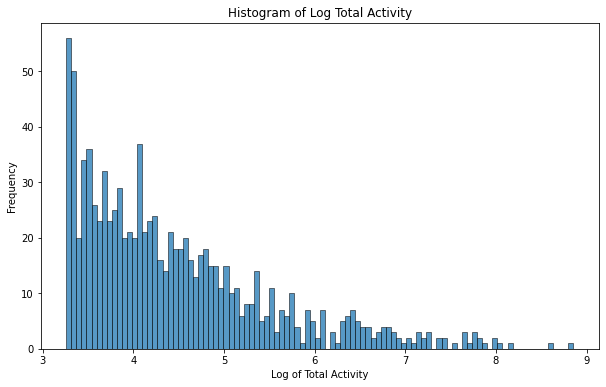

In [142]:
# The data is highly skewed so we log transform the data
# Log Transformation
active_users['LogTotalActivity'] = np.log(active_users['TotalActivity'])

# Histogram with Log Scale
plt.figure(figsize=(10, 6))
sns.histplot(active_users['LogTotalActivity'].dropna(), kde=False, bins=100)  # Adjust bins as needed
plt.title('Histogram of Log Total Activity')
plt.xlabel('Log of Total Activity')
plt.ylabel('Frequency')
plt.show()

In [143]:
active_users['TotalActivity'].describe()

count     964.000000
mean      196.756224
std       470.096607
min        26.000000
25%        38.000000
50%        66.000000
75%       141.250000
max      7016.000000
Name: TotalActivity, dtype: float64

In [144]:
active_users['TotalActivity'].quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99])


0.25      38.00
0.50      66.00
0.75     141.25
0.90     397.10
0.95     800.80
0.99    2358.86
Name: TotalActivity, dtype: float64

In [154]:
most_active = active_users[active_users['TotalActivity'] >= active_users['TotalActivity'].quantile(0.90)]
most_active

,Id,Reputation,CreationDate,LastAccessDate,Views,UpVotes,DownVotes,OwnerUserId,PostCount,UserId,CommentCount,TotalActivity,LogTotalActivity
23,23,16227,2012-12-04 21:49:39.360,2015-02-14 02:38:09.917,1449,803,54,23.0,160.0,23.0,277.0,437.0,6.079933
96,101,9601,2012-12-05 05:03:38.487,2023-08-30 10:27:39.800,2195,2259,3113,101.0,70.0,101.0,358.0,428.0,6.059123
109,115,91134,2012-12-05 11:40:42.477,2023-09-02 00:57:59.273,5329,5504,2715,115.0,833.0,115.0,4751.0,5584.0,8.627661
123,130,47394,2012-12-05 21:07:06.017,2023-08-31 06:00:47.800,3958,2344,338,130.0,377.0,130.0,2031.0,2408.0,7.786552
159,169,8791,2012-12-10 15:25:38.923,2023-02-25 05:00:02.240,918,934,891,169.0,124.0,169.0,1117.0,1241.0,7.123673
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27321,32479,1,2020-05-08 19:37:09.940,2023-09-03 02:46:36.197,3295,310,49,32479.0,379.0,32479.0,474.0,853.0,6.748760
31566,38304,10459,2021-05-10 07:46:09.173,2023-08-29 04:35:44.670,680,375,205,38304.0,128.0,38304.0,607.0,735.0,6.599870
33780,41763,1,2022-01-23 22:31:49.303,2023-09-02 22:13:29.533,14630,1219,106,41763.0,129.0,41763.0,742.0,871.0,6.769642
34261,42320,7475,2022-03-03 00:24:15.180,2023-08-22 07:22:22.197,447,484,516,42320.0,110.0,42320.0,460.0,570.0,6.345636
